In [3]:
from neuralop.models import FNO
import torch
import pathlib
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from tqdm.notebook import tqdm
from IPython.display import HTML

from acoustic_no.data import ShuffledAcousticDataset

In [4]:
# Use the GPU if available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cpu


In [5]:
# Load the dataset
dataset = ShuffledAcousticDataset(
    dataset_dir=pathlib.Path("../resources/dataset/processed"),
)
print(f"Dataset size: {len(dataset)}")

Dataset size: 9216


In [7]:
depth = dataset.depth

In [8]:
model = FNO(
    n_modes=(16, 16),
    in_channels=depth * 3 + 1,
    out_channels=depth,
    hidden_channels=64,
    projection_channel_ratio=2,
)
model.load_state_dict(
    torch.load(
        "../ckpt/best_model_state_dict.pt",
        map_location=device,
        weights_only=False
    )
)
model.to(device)

FNO(
  (positional_embedding): GridEmbeddingND()
  (fno_blocks): FNOBlocks(
    (convs): ModuleList(
      (0-3): 4 x SpectralConv(
        (weight): DenseTensor(shape=torch.Size([64, 64, 16, 9]), rank=None)
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Flattened1dConv(
        (conv): Conv1d(64, 64, kernel_size=(1,), stride=(1,), bias=False)
      )
    )
    (channel_mlp): ModuleList(
      (0-3): 4 x ChannelMLP(
        (fcs): ModuleList(
          (0): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
          (1): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
        )
      )
    )
    (channel_mlp_skips): ModuleList(
      (0-3): 4 x SoftGating()
    )
  )
  (lifting): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(195, 128, kernel_size=(1,), stride=(1,))
      (1): Conv1d(128, 64, kernel_size=(1,), stride=(1,))
    )
  )
  (projection): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (1): Conv1d(128, 64, kernel

In [20]:
data = dataset[5]
x = data["x"].unsqueeze(0).to(device)
y = data["y"]
y_pred = model(x).squeeze(0).cpu().detach().numpy()
print(f"Input shape: {x.shape}")
print(f"Output shape: {y_pred.shape}")
print(f"Target shape: {y.shape}")

Input shape: torch.Size([1, 193, 64, 64])
Output shape: (64, 64, 64)
Target shape: torch.Size([64, 64, 64])


Animation Progress:   0%|          | 0/64 [00:00<?, ?step/s]

MovieWriter imagemagick unavailable; using Pillow instead.


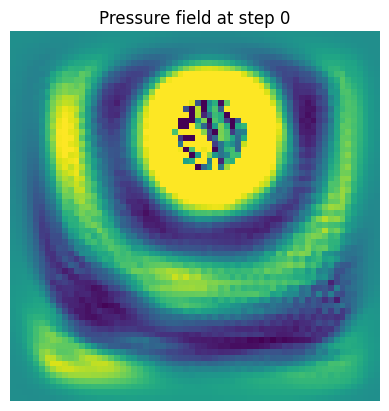

In [21]:
# Tqdm progress bar for the simulation
pbar = tqdm(total=depth, desc="Animation Progress", unit="step")

# Generate the animation for the pressure field.
def update(frame):
    ax.clear()
    im = ax.imshow(
        y_pred[frame].T,
        interpolation='nearest',
        vmin=-10.0,
        vmax=10.0
    )
    ax.set_title(f'Pressure field at step {frame}')
    ax.axis('off')
    # Update the progress bar
    pbar.update(1)
    # Close the progress bar when done
    if frame == depth - 1:
        pbar.close()
    return [im]

fig, ax = plt.subplots()

# Wrap the animation generation with tqdm for progress tracking
ani = FuncAnimation(
    fig,
    update,
    frames=range(depth),
    interval=1000 / 60,
    blit=False,
    repeat=True,
)

# Save gif
ani.save("pred_pressure_field.gif", fps=60, writer='imagemagick')
# Display the animation in the notebook
HTML(ani.to_jshtml())